# Figure S5. Enhancer activity relative to the distance to the nearest TSS

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
import bioframe as bf
import time
import warnings
warnings.filterwarnings('ignore')
#define useful functions
#set seaborn theme for nice figures
sns.set_theme(style="ticks",rc={"axes.spines.right": False, "axes.spines.top": False, 'font.size': 10,
								"figure.facecolor":(0.0, 0.0, 0.0, 0.0), "axes.facecolor":(0.0, 0.0, 0.0, 0.0)},
			  font='arial')
#import key tables
fig_out = r'..\figures'

 - design plotting functions

In [2]:
def plot_jointplot(data, x_col, y_col,xlogbase=10, ylogbase=2, hue = None, hue_ord = None, pal = None, col = 'firebrick', xlims = (-0.5,6.5), ylims = (-7,5), units = '', xy_labels = [''], title = None, hue_title = None, pcc = False, savefig = False, fig_name = None):
	g = sns.jointplot(data = data, x=x_col, y=y_col, hue=hue, hue_order=hue_ord, palette=pal, s=15, color= col, joint_kws=dict(alpha = 0.5),
				   ylim=ylims, xlim=xlims, height=5)
	if xy_labels != ['']:
		g.set_axis_labels(xy_labels[0]  + units, xy_labels[1] +  units, fontsize=12)
	#add pearsons correlation, but unlog first
	if pcc == True: 
		r,p = stats.spearmanr(xlogbase ** data[x_col], ylogbase**data[y_col], nan_policy='omit')
		g.ax_joint.annotate(f'PCC = {r:.3f},\np = {p:.3e}', xy=(0.05, 0.07), xycoords='axes fraction',
							ha='left', va='center',
							bbox={'boxstyle': 'round', 'fc': 'mistyrose', 'ec': 'black'})
	if title != None: g.ax_joint.set_title(title, y=0.95, fontsize = 12)
	if hue_title != None: sns.move_legend(g.ax_joint, loc='upper left', bbox_to_anchor=(0.01, 0.9), title = hue_title, frameon=False)
	if savefig == True:
		if fig_name == None: 
			g.savefig(os.path.join(fig_out,'fig_' + time.strftime("%Y%m%d-%H%M%S")), dpi=300, transparent=True, bbox_inches='tight')
		else: 
			g.savefig(os.path.join(fig_out,fig_name), dpi=300, transparent=True, bbox_inches='tight')
	del(g)

## Figure S3
- This is for MCF10A
- Import enhancer distance to nearest TSS table generated for Fig. 1C
- Add pseudocount of 1 of to be able to log values

In [15]:
os.chdir('..\data')
#MPRA data in MCF10A
df = pd.read_excel('Table S3.xlsx', sheet_name='MCF10A_WT_p53KO')
df.drop(columns=['obs_score','gc','obs_p53'], inplace=True)
df = df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'WT')]
#Distance between enhnancer and the nearest TSS
distance_tss = pd.read_csv('Distance_tss_all.csv')
distance_tss['loc'] = distance_tss.apply(lambda row: row.p63RE_chrom + '_' + str(row.p63RE_start )+ '_' + str(row.p63RE_stop), axis='columns')
df = df.merge(distance_tss[['distance_tss','loc']], how='left', on='loc')
#add pseodocount for log scale later
df.distance_tss = df.distance_tss + 1
#sort by activity for better visualization
order = ["Unchanged", "Activating", "Repressing"]
df['activity'] = pd.Categorical(df['activity'], order)
df.sort_values(by='activity', inplace=True)
df['log2(RNA/DNA)'] = np.log2(df['RNA/DNA'])
df['log(distance_tss)'] = np.log10(df['distance_tss'])
df.sample(5)

,loc,enhancer_variant,cell_line,RNA/DNA,activity,p63RE_class,strand,p63RE_type,distance_tss,log2(RNA/DNA),log(distance_tss)
806,chr4_52051956_52051975,WT,MCF10A,10.373403,Activating,primary,+,p53RE+p63RE,653,3.374817,2.814913
5750,chr1_163282566_163282585,WT,MCF10A,0.775462,Activating,primary,+,p53RE+p63RE,39207,-0.366871,4.593364
8859,chr16_51922622_51922636,WT,MCF10A,0.583084,Unchanged,tertiary,+,Unique p63RE,151300,-0.778225,5.179839
7849,chr6_21264123_21264147,WT,MCF10A,1.370650,Unchanged,primary,+,Unique p63RE,247746,0.454860,5.394007
2198,chr18_46663687_46663706,WT,MCF10A,0.746055,Unchanged,primary,-,p53RE+p63RE,6655,-0.422645,3.823148


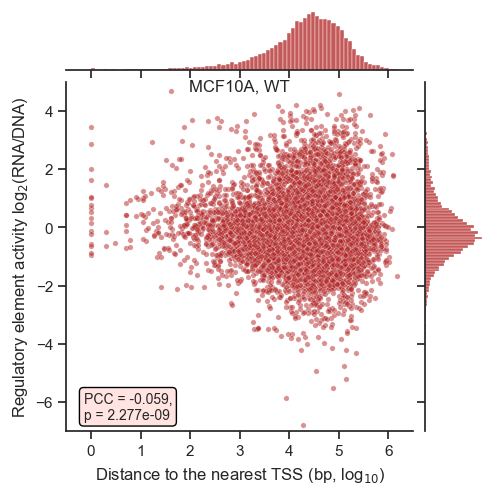

In [16]:
plot_jointplot(data=df, x_col='log(distance_tss)', y_col='log2(RNA/DNA)',
			   xy_labels = ['Distance to the nearest TSS (bp, log' + r'$_{10}$' + ')', 'Regulatory element activity log' + r'$_{2}$'+'(RNA/DNA)'], 
			   title = 'MCF10A, WT', pcc = True, savefig = True, fig_name = 'S3.png')